In [1]:
import re
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Concatenate,
    Multiply,
    Attention,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

2024-06-09 15:23:35.536064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [3]:
# users.head(10)

In [4]:
# items.head()

In [5]:
# ratings.head()

In [3]:
# Dropping the header row
users.drop(users.index[0], inplace=True)
items.drop(items.index[0], inplace=True)
ratings.drop(ratings.index[0], inplace=True)

In [7]:
# users.head()

In [8]:
# items.head()

In [9]:
# ratings.head()

In [4]:
# Merge the three forms of data
df = pd.merge(users, ratings, on="user_id")

df = pd.merge(items, df, on="isbn")
# df.head()

In [11]:
# df.shape

In [12]:
# df.describe()

In [13]:
# df.info()

In [5]:
# Check for missing values
df.isnull().sum()

isbn                        0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   2
img_s                       0
img_m                       0
img_l                       0
user_id                     0
location                    0
age                    277845
rating                      0
dtype: int64

In [6]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
user_id                0
location               0
age                    0
rating                 0
dtype: int64

In [16]:
# df.info()

In [7]:
# Convert the data types
df["user_id"] = df["user_id"].astype(int)
df["isbn"] = df["isbn"].astype(str)
df["rating"] = df["rating"].astype(float)
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [8]:
# Re-index user_id and isbn
user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
isbn_mapping = {isbn: idx for idx, isbn in enumerate(df["isbn"].unique())}

df["user_id"] = df["user_id"].map(user_id_mapping)
df["isbn"] = df["isbn"].map(isbn_mapping)

In [19]:
# # Authors with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=df['book_author'].value_counts().head(50), y=df['book_author'].value_counts().head(50).index)
# plt.xlabel("Count")
# plt.ylabel("Author")
# plt.title("Authors with Most Ratings", size=20)

In [20]:
# ds = df["book_title"].value_counts().head(50).reset_index()
# ds.columns = ["book", "count"]
# ds.head()

In [21]:
# # Books with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=ds['count'], y=ds['book'])
# plt.xlabel("Count")
# plt.ylabel("Book")
# plt.title("Books with Most Ratings", size=20)

# Split the dataset into training, validation, and test sets

In [9]:
# Split the dataset into training, validation, and test sets
# Splits the original dataset df into two parts: 80% of the data is assigned to train, and 20% is assigned to test.
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Splits the train dataset into two parts: 80% of the data is assigned to train, and 20% is assigned to val.
train, val = train_test_split(train, test_size=0.2, random_state=42)
# In the end, we have train: 64% of the original dataset, val: 16% of the original dataset, test: 20% of the original dataset.

In [10]:
# Extracting the input arrays
user_ids_train = train["user_id"].values
item_ids_train = train["isbn"].values
ratings_train = train["rating"].values.astype(float)
user_ids_val = val["user_id"].values
item_ids_val = val["isbn"].values
ratings_val = val["rating"].values.astype(float)

In [11]:
# Verify data types and ranges
print(user_ids_train.dtype)  # Should be integer type
print(item_ids_train.dtype)  # Should be integer type
print(ratings_train.dtype)  # Should be float type

print(
    user_ids_train.max(), len(user_id_mapping)
)  # Max value should be less than len(user_id_mapping)
print(
    item_ids_train.max(), len(isbn_mapping)
)  # Max value should be less than len(isbn_mapping)

int64
int64
float64
53887 53888
229012 229013


In [12]:
# Matrix Factorization with Neural Networks (MF-NN)
# This leverages collaborative filtering with deep learning for user-item interaction modeling.


# Define MF-NN Model
def mf_nn_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    concat = Concatenate()([user_vector, item_vector])

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(concat)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [13]:
num_users = len(user_id_mapping)
num_items = len(isbn_mapping)
# This is the dimension of the embedding vectors for both users and items.
# It determines the size of the latent factors space where users and items are projected. A higher dimension can capture more complex interactions but also increases the computational complexity and risk of overfitting.
embedding_dim = 50

In [62]:
# Train the MF-NN model
model_mf_nn = mf_nn_model(num_users, num_items, embedding_dim)
model_mf_nn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │  2,694,400 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │ 11,450,650 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,166,299 (54.04 MB)

 Trainable params: 14,166,299 (54.04 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model_mf_nn.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=10,  
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[early_stopping],
)

Epoch 1/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4340s 287ms/step - loss: 15.1587 - val_loss: 13.1936
Epoch 2/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4635s 308ms/step - loss: 13.1489 - val_loss: 13.0591
Epoch 3/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4808s 319ms/step - loss: 13.0625 - val_loss: 12.9294
Epoch 4/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4810s 319ms/step - loss: 13.0226 - val_loss: 13.2007
Epoch 5/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4778s 317ms/step - loss: 12.9370 - val_loss: 13.2420
Epoch 6/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 3870s 257ms/step - loss: 12.9534 - val_loss: 12.9994


In [64]:
model_mf_nn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │  2,694,400 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │ 11,450,650 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,166,299 (54.04 MB)

 Trainable params: 14,166,299 (54.04 MB)

 Non-trainable params: 0 (0.00 B)

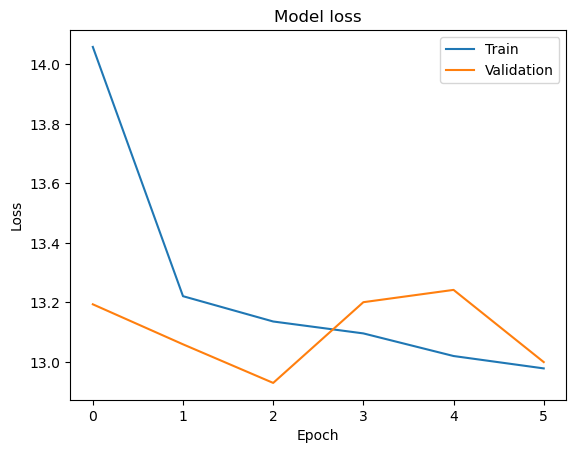

In [16]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [17]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_mf_nn.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 208s 44ms/step - loss: 12.9184
Test Loss: 12.970344543457031


In [18]:
# Evaluate on the validation set
val_loss = model_mf_nn.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 150s 40ms/step - loss: 12.9339
Validation Loss: 12.929356575012207


In [19]:
# Optionally, predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_mf_nn.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_mf_nn.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step
Prediction Validation: [[5.6159997]
 [3.7964523]
 [2.5655007]
 ...
 [0.6028257]
 [1.9220749]
 [1.5020645]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step
Prediction Test: [[0.7826205]
 [4.696977 ]
 [1.641799 ]
 ...
 [4.0189247]
 [2.1809802]
 [0.9518209]]
Validation RMSE: 3.4069072215689573, Test RMSE: 3.412917382049136


# Book recommendations

In [20]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_mf_nn.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)

2134/2134 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Top 10 Recommended Books for User 3885
                                             book_title          book_author
5225        Garzanti - Gli Elefanti: Creatura Di Sabbia        T Ben Jelloun
2015  Afrikanisches Fieber. Erfahrungen aus vierzig ...  Ryszard Kapuscinski
700                                          I And Thou         Martin Buber
6025                A Grave Denied: A Kate Shugak Novel        Dana Stabenow
3273                                 Buddha of Suburbia       Hanif Kureishi
5161  Dana and the Calendar Man (Harlequin American ...        Hiram Bingham
566                                         Three Junes          JULIA GLASS
26                             Flood : Mississippi 1927        Kathleen Duey
2661  How to Talk So Kids Will Listen and Listen So ...          Adele Faber
3642                                       Life Penalty         Joy Fielding


In [21]:
user_id = 3885
# Get the indices of the highest rated books for a particular user from the test set
# Specify the user ID here
user_test_indices = np.where(user_ids_test == user_id)[0]
user_test_ratings = ratings_test[user_test_indices]
highest_rated_indices = np.argsort(user_test_ratings)[-10:][
    ::-1
]  # Get indices of top 10 highest rated books

# Map indices back to book titles and authors
highest_rated_books = items.iloc[
    item_ids_test[user_test_indices[highest_rated_indices]]
][["book_title", "book_author"]]

# Output the highest rated books for the user
print(f"Top 10 highest rated books by user {user_id}:")
for idx, (book_title, book_author) in enumerate(
    zip(highest_rated_books["book_title"], highest_rated_books["book_author"])
):
    print(f"{idx+1}. {book_title} by {book_author}")

Top 10 highest rated books by user 3885:
1. A Hiker's Companion: 12,000 Miles of Trail-Tested Wisdom by Cindy Ross
2. Pet Sematary by Stephen King
3. The Murders of Richard III by Elizabeth Peters
4. Night Prey by Carol Davis Luce
5. Black Livingstone: A True Tale of Adventure in the Nineteenth-Century Congo by Pagan Kennedy
6. Tales from the Dark Tower by Joseph Vargo
7. Els intelÂ¨lectuals, avui (Treballs de la SecciÃ³ de Filosofia i CiÃ¨ncies Socials) by Jordi Berrio
8. French Lessons: A Memoir by Alice Kaplan
9. The Cat Who Tailed a Thief by Lilian Jackson Braun
10. She'S Having His Baby (Accidental Dads) (Harlequin American Romance, 751) by Linda Randall Wisdom


In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Create a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5, metric="cosine", n_jobs=-1)

# Define lists to store training and validation RMSE values
train_rmse_values = []
val_rmse_values = []

# Define the number of epochs
epochs = 10

# Loop through each epoch
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}: ")
    
    # Fit the model on the training data
    knn_model.fit(train[["user_id", "isbn"]], train["rating"])

    # Predict ratings for the training set
    train_predictions = knn_model.predict(train[["user_id", "isbn"]])

    # Calculate RMSE on training set
    train_rmse = mean_squared_error(train["rating"], train_predictions, squared=False)
    train_rmse_values.append(train_rmse)

    # Predict ratings for the validation set
    val_predictions = knn_model.predict(val[["user_id", "isbn"]])

    # Calculate RMSE on validation set
    val_rmse = mean_squared_error(val["rating"], val_predictions, squared=False)
    val_rmse_values.append(val_rmse)

    # Print the training progress
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# Plot the training and validation RMSE values
# plt.plot(range(1, epochs + 1), train_rmse_values, label="Train RMSE")
# plt.plot(range(1, epochs + 1), val_rmse_values, label="Validation RMSE")
# plt.xlabel("Epochs")
# plt.ylabel("RMSE")
# plt.title("Training and Validation RMSE")
# plt.legend()
# plt.show()

Epoch 1/10: 


KeyboardInterrupt: 

In [26]:
def get_user_ratings(user_id, df):
    # Filter the DataFrame for the specified user
    user_ratings = df[df["user_id"] == user_id]

    # Sort the ratings in descending order
    user_ratings_sorted = user_ratings.sort_values(by="rating", ascending=False)

    return user_ratings_sorted


# Example usage
selected_user_id = 3885 
user_ratings = get_user_ratings(selected_user_id, df)

print(
    f"All books rated by user {selected_user_id} in descending order of rating:\n",
    user_ratings[["book_title", "book_author", "rating"]],
)

All books rated by user 3885 in descending order of rating:
                                                book_title  \
291520                                        Desert Dawn   
265686           The Vagina Monologues: The V-Day Edition   
702467                                      Five Chimneys   
441528  Dragons of Winter Night (Dragonlance: Dragonla...   
115090                          Dude, Where's My Country?   
...                                                   ...   
380702  The End Of The Dream The Golden Boy Who Never ...   
385133                                        The Surgeon   
388818  The Rules(TM) : Time-Tested Secrets for Captur...   
390334  The Nine Emotional Lives of Cats : A Journey I...   
931516                                   Guardsman of Gor   

                      book_author  rating  
291520              Jeanne D'Haem     8.0  
265686                 Eve Ensler     8.0  
702467               Olga Lengyel     8.0  
441528              Margaret W

In [50]:
import random
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds(42)

In [51]:
from tensorflow.keras.layers import Reshape


def ncf_attention_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    interaction = Multiply()([user_vector, item_vector])

    # Reshape interaction tensor for compatibility with Attention layer
    interaction_reshaped = Reshape((1, embedding_dim))(interaction)

    attention = Attention()([interaction_reshaped, interaction_reshaped])
    attention_vector = Flatten()(attention)

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(attention_vector)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [65]:
# Train the NCF Attention model
model_ncf_attention = ncf_attention_model(num_users, num_items, embedding_dim)
model_ncf_attention.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 50)     │  2,694,400 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 50)     │ 11,450,650 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 50)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 50)        │          0 │ flatten_7[0][0],  │
│ (Multiply)          │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 50)     │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 50)     │          0 │ reshape_1[0][0],  │
│ (Attention)         │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 50)        │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      6,528 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,159,899 (54.02 MB)

 Trainable params: 14,159,899 (54.02 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model_ncf_attention.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=10,
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[early_stopping],
)

Epoch 1/10


/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4780s 315ms/step - loss: 16.0440 - val_loss: 14.9490
Epoch 2/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4742s 315ms/step - loss: 14.9783 - val_loss: 14.9265
Epoch 3/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4733s 314ms/step - loss: 14.9651 - val_loss: 14.9236
Epoch 4/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4213s 280ms/step - loss: 14.9626 - val_loss: 14.9220
Epoch 5/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4998s 332ms/step - loss: 14.9612 - val_loss: 14.9210
Epoch 6/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 5003s 332ms/step - loss: 14.9603 - val_loss: 14.9203
Epoch 7/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4992s 331ms/step - loss: 14.9597 - val_loss: 14.9198
Epoch 8/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4861s 323ms/step - loss: 14.9592 - val_loss: 14.9194
Epoch 9/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 5017s 333ms/step - loss: 14.9587 - val_loss: 14.9189
Epoch 10/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 5091s 338ms/step - loss: 14.9582 - val_loss: 14.9185


In [63]:
model_ncf_attention.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │  2,694,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │ 11,450,650 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50)        │          0 │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 50)     │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 50)     │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      6,528 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,479,699 (162.05 MB)

 Trainable params: 14,159,899 (54.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,319,800 (108.03 MB)

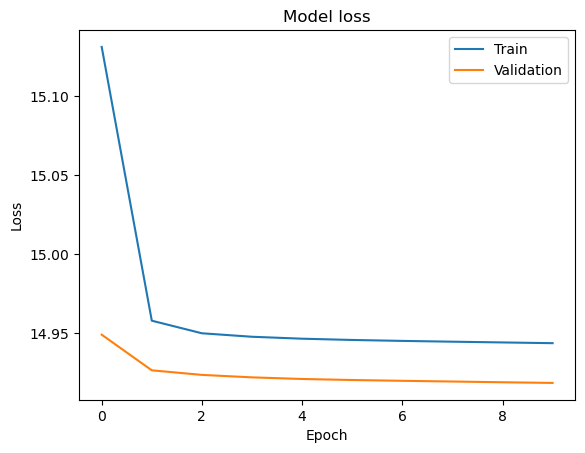

In [54]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [55]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_ncf_attention.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 202s 43ms/step - loss: 14.9772
Test Loss: 14.947552680969238


In [56]:
# Evaluate on the validation set
val_loss = model_ncf_attention.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 160s 42ms/step - loss: 14.8849
Validation Loss: 14.918474197387695


In [57]:
# Predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_ncf_attention.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_ncf_attention.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3767/3767 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step
Prediction Validation: [[2.7970424]
 [2.7970424]
 [2.7970424]
 ...
 [2.7970424]
 [2.7970424]
 [2.7970424]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step
Prediction Test: [[2.7970424]
 [2.7970424]
 [2.7970424]
 ...
 [2.7970424]
 [2.7970424]
 [2.7970424]]
Validation RMSE: 3.8619103945186306, Test RMSE: 3.865672807609308


# Book recommendation

In [58]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_ncf_attention.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)

2134/2134 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step
Top 10 Recommended Books for User 3885
                                               book_title        book_author
3                                    Decision in Normandy       Carlo D'Este
117078                                Lady and the Outlaw      Joyce Brandon
117006                                     Girls Out Late  JACQUELINE WILSON
117008  Of Beetles and Angels : A Boy's Remarkable Jou...       Mawi Asgedom
117017  O Is for Outlaw (Kinsey Millhone Mysteries (Au...        Sue Grafton
117020                                        Hug a Teddy       Jim. Erskine
117023  The Asimov Chronicles: Fifty Years of Isaac As...       Isaac Asimov
117025          An Unsuitable Job for a Woman (BBC Radio)        P. D. James
117034  Bountiful Women: Large Women's Secrets for Liv...     Bonnie Bernell
117035  Evolution's End : Claiming the Potential of Ou...   Joseph C. Pearce


: 